In [682]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import os
from PIL import Image
from keras.models import Sequential
from keras.layers import Conv2D,Dropout,Dense,Flatten,Conv2DTranspose,BatchNormalization,LeakyReLU,Reshape
from keras.optimizers import Adam
from keras.initializers import RandomNormal

In [683]:
path = []
celeb = "img_align_celeba/img_align_celeba/"
for i in os.listdir(celeb):
    if '.jpg' in i:
        path.append(os.path.join(celeb,i))

In [684]:
path = path[:5000]

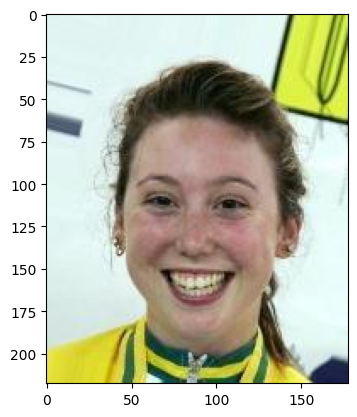

In [685]:
img = Image.open(path[69])
plt.imshow(img)
plt.show()

In [686]:
img.size

(178, 218)

In [687]:
images = [np.array((Image.open(i).crop((26, 51, 154, 179))).resize((64,64))) for i in path] #Crop image to 128,128 box and resize image to 64,64

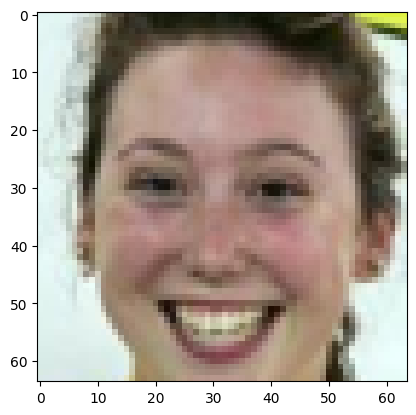

In [688]:
plt.imshow(images[69])
plt.show()

In [689]:
#X_train = np.array(images).astype(np.float32) / 255.0
X_train = np.array(images).astype(np.float32)
X_train = (X_train / 127.5) - 1.0

In [690]:
X_train.shape

(5000, 64, 64, 3)

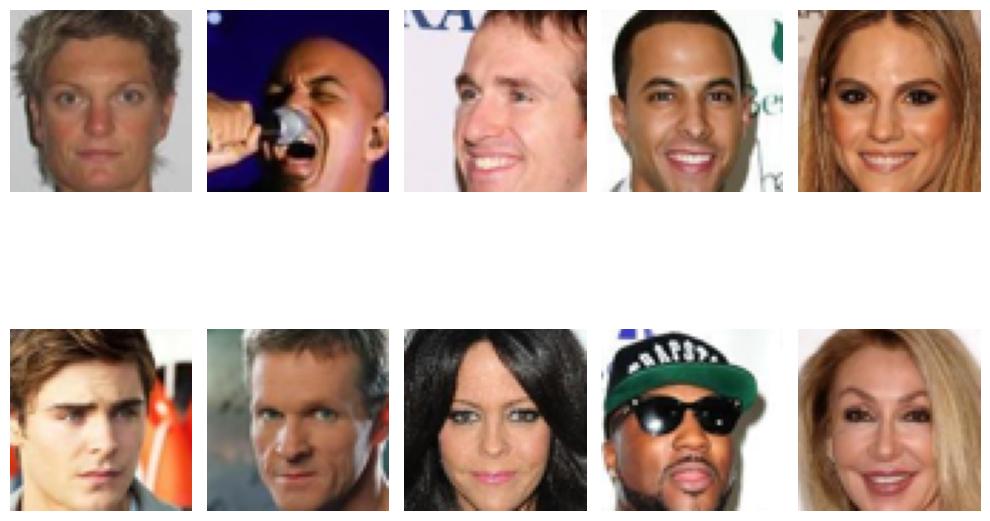

In [691]:
plt.figure(figsize = (10,8))
i,k = 100,1

while k <= 10:
    plt.subplot(2,5,k)
    plt.imshow((X_train[i]+1)/2)
    plt.axis('off')
    k += 1
    i += 100

plt.tight_layout()
plt.show()

In [692]:
noise_shape = 100

In [693]:
generator = Sequential([ #Up sampling
        Dense(4*4*512), #8192 units
        Reshape([4,4,512]), #4,4,512
        Conv2DTranspose(256,kernel_size = 4, strides = 2, padding = "same"), #strides double the size to 8,8,256
        LeakyReLU(alpha = 0.2), # x if x >= 0 else 0.2 x 
        BatchNormalization(), #Scales  to variance 1
        Conv2DTranspose(128,kernel_size = 4, strides = 2, padding = "same"), #again doubles the size to to 16,16,128
        LeakyReLU(alpha = 0.2),
        BatchNormalization(),
        Conv2DTranspose(64,kernel_size = 4, strides = 2, padding = "same"), #32,32,64
        LeakyReLU(alpha = 0.2),
        BatchNormalization(),
        Conv2DTranspose(3,kernel_size = 4,strides = 2, padding = "same",activation = "tanh") #64,64,3 range 0-1
])

In [694]:
generator.summary()

Model: "sequential_76"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_51 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_26 (Reshape)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_104            │ ?                      │   0 (unbuilt) │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_136 (LeakyReLU)     │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_95          │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_105            │ ?                      │   0 (unbuilt) │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_137 (LeakyReLU)     │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_96          │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_106            │ ?                      │   0 (unbuilt) │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_138 (LeakyReLU)     │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_97          │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_107            │ ?                      │   0 (unbuilt) │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [695]:
discriminator = Sequential([ #Down sampling
    Conv2D(32,kernel_size = 4,strides = 2,padding = "same"), #stride halfs the image size to 32,32,32
    Conv2D(64,kernel_size = 3,strides = 2,padding = "same"), #16,16,64
    LeakyReLU(alpha = 0.2),
    #BatchNormalization(),
    Dropout(0.5),
    Conv2D(128,kernel_size = 3,strides = 2, padding = "same"), #8,8,128
    LeakyReLU(alpha = 0.2),
    #BatchNormalization(),
    Conv2D(256,kernel_size = 4,strides = 2, padding = "same"), #4,4,256
    LeakyReLU(alpha = 0.2),
    Flatten(), #4*4*256 = 4096 units
    Dropout(0.5),
    Dense(1,activation = "sigmoid") #range 0-1
])

In [696]:
discriminator.summary()

Model: "sequential_77"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_66 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_67 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_139 (LeakyReLU)     │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_44 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_68 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_140 (LeakyReLU)     │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_69 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_141 (LeakyReLU)     │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_25 (Flatten)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_45 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_52 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [697]:
gan = Sequential([
    generator,
    discriminator
])

In [698]:
discriminator.compile(optimizer=Adam(learning_rate=0.00001, beta_1=0.5),loss = 'binary_crossentropy')
discriminator.trainable = False #Freeze the discriminator when generator is training

In [699]:
gan.compile(optimizer=Adam(learning_rate=0.0002, beta_1=0.5), loss = 'binary_crossentropy')

In [700]:
gan.layers

[<Sequential name=sequential_76, built=False>,
 <Sequential name=sequential_77, built=False>]

In [701]:
gan.summary()

Model: "sequential_78"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_76 (Sequential)      │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_77 (Sequential)      │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

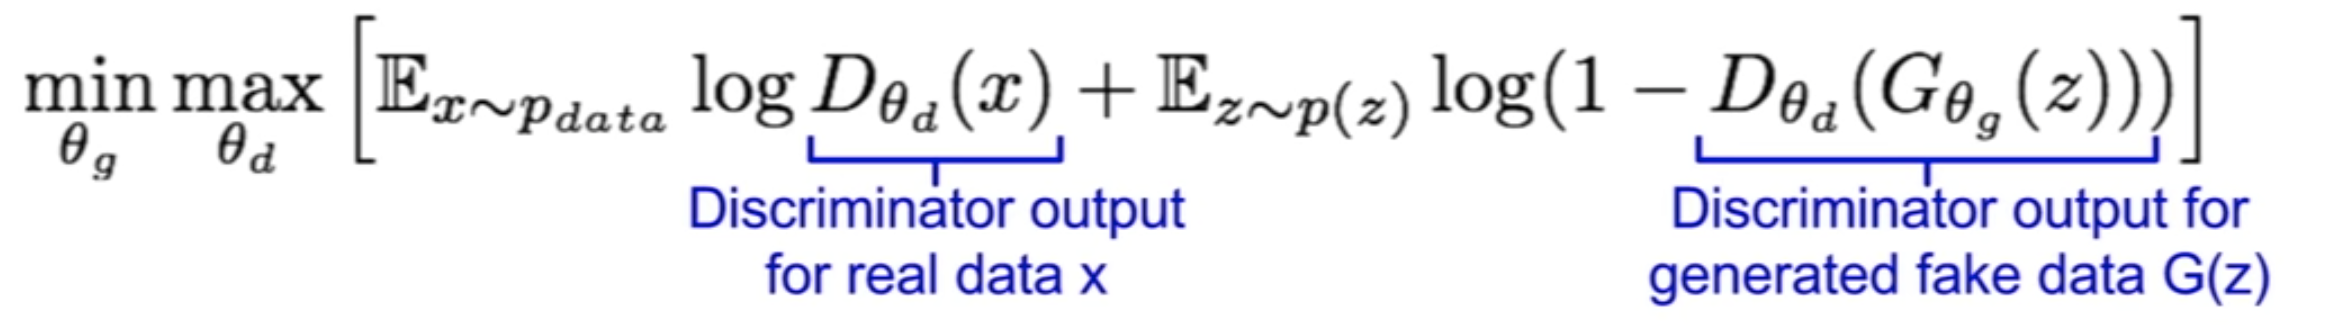

In [702]:
epochs = 100
batch_size = 128

In [703]:
X_train.shape

(5000, 64, 64, 3)

In [704]:
batches = X_train.shape[0]//batch_size
batches

39

In [705]:
d_loss = []
g_loss = []

Epoch:  0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step


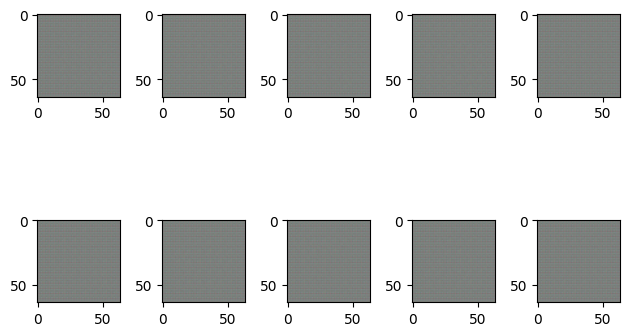

Epoch: 1,  Loss: D_real = 0.6515262126922607, D_fake = 0.6522418260574341,  G = 0.3928263187408447
Epoch:  1
Epoch: 2,  Loss: D_real = 0.6029035449028015, D_fake = 0.6028707027435303,  G = 0.21865718066692352
Epoch:  2
Epoch: 3,  Loss: D_real = 0.5201800465583801, D_fake = 0.518466055393219,  G = 0.14749214053153992
Epoch:  3
Epoch: 4,  Loss: D_real = 0.438525915145874, D_fake = 0.437163382768631,  G = 0.11103032529354095
Epoch:  4
Epoch: 5,  Loss: D_real = 0.3850666880607605, D_fake = 0.38408753275871277,  G = 0.08908870816230774
Epoch:  5
Epoch: 6,  Loss: D_real = 0.3488709032535553, D_fake = 0.3481278121471405,  G = 0.07443815469741821
Epoch:  6
Epoch: 7,  Loss: D_real = 0.3228897154331207, D_fake = 0.32229942083358765,  G = 0.06394803524017334
Epoch:  7
Epoch: 8,  Loss: D_real = 0.3033737540245056, D_fake = 0.30288827419281006,  G = 0.056062422692775726
Epoch:  8
Epoch: 9,  Loss: D_real = 0.28816723823547363, D_fake = 0.2877573072910309,  G = 0.04991189390420914
Epoch:  9
Epoch: 10

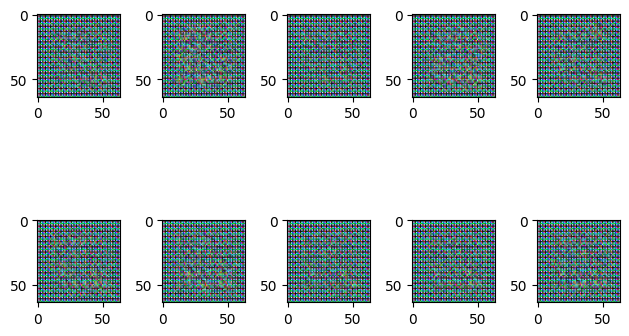

Epoch: 11,  Loss: D_real = 0.26604312658309937, D_fake = 0.26573413610458374,  G = 0.040938086807727814
Epoch:  11
Epoch: 12,  Loss: D_real = 0.257790744304657, D_fake = 0.25751838088035583,  G = 0.03756284713745117
Epoch:  12
Epoch: 13,  Loss: D_real = 0.25097861886024475, D_fake = 0.2507413923740387,  G = 0.034704484045505524
Epoch:  13
Epoch: 14,  Loss: D_real = 0.24552874267101288, D_fake = 0.2453194409608841,  G = 0.03228132426738739
Epoch:  14
Epoch: 15,  Loss: D_real = 0.24090401828289032, D_fake = 0.2407127171754837,  G = 0.03028905764222145
Epoch:  15
Epoch: 16,  Loss: D_real = 0.23731760680675507, D_fake = 0.2371612936258316,  G = 0.02862941287457943
Epoch:  16
Epoch: 17,  Loss: D_real = 0.27653399109840393, D_fake = 0.2774941027164459,  G = 0.03420799598097801
Epoch:  17
Epoch: 18,  Loss: D_real = 0.32201704382896423, D_fake = 0.32248878479003906,  G = 0.05104895681142807
Epoch:  18
Epoch: 19,  Loss: D_real = 0.3531096875667572, D_fake = 0.35339415073394775,  G = 0.073201902

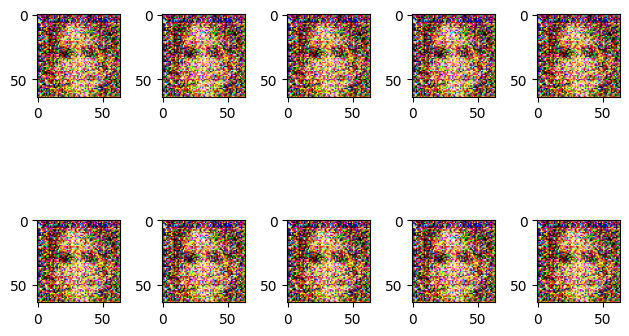

Epoch: 21,  Loss: D_real = 0.3972601294517517, D_fake = 0.39742594957351685,  G = 0.12442536652088165
Epoch:  21
Epoch: 22,  Loss: D_real = 0.41500136256217957, D_fake = 0.41515257954597473,  G = 0.14886121451854706
Epoch:  22
Epoch: 23,  Loss: D_real = 0.43083056807518005, D_fake = 0.43096107244491577,  G = 0.1717870533466339
Epoch:  23
Epoch: 24,  Loss: D_real = 0.4451168477535248, D_fake = 0.4452396631240845,  G = 0.19323429465293884
Epoch:  24
Epoch: 25,  Loss: D_real = 0.45795345306396484, D_fake = 0.45805707573890686,  G = 0.21386857330799103
Epoch:  25
Epoch: 26,  Loss: D_real = 0.46951550245285034, D_fake = 0.46962276101112366,  G = 0.23281237483024597
Epoch:  26
Epoch: 27,  Loss: D_real = 0.4814465045928955, D_fake = 0.4815409183502197,  G = 0.24849246442317963
Epoch:  27
Epoch: 28,  Loss: D_real = 0.49159035086631775, D_fake = 0.49167388677597046,  G = 0.265001118183136
Epoch:  28
Epoch: 29,  Loss: D_real = 0.5010910034179688, D_fake = 0.5011882781982422,  G = 0.2797335982322

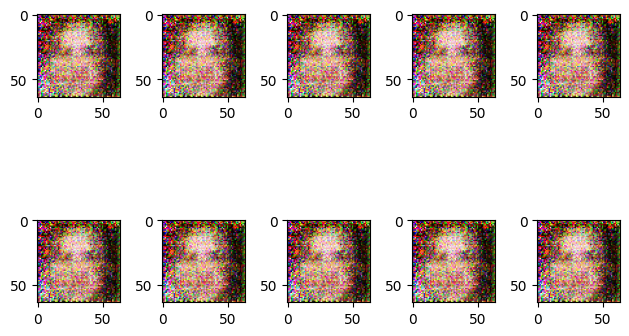

Epoch: 31,  Loss: D_real = 0.5180311799049377, D_fake = 0.5180864334106445,  G = 0.3072861433029175
Epoch:  31
Epoch: 32,  Loss: D_real = 0.5252236127853394, D_fake = 0.525285542011261,  G = 0.320095956325531
Epoch:  32
Epoch: 33,  Loss: D_real = 0.5319979190826416, D_fake = 0.5320566296577454,  G = 0.3316304385662079
Epoch:  33
Epoch: 34,  Loss: D_real = 0.538198709487915, D_fake = 0.5382519960403442,  G = 0.34253209829330444
Epoch:  34
Epoch: 35,  Loss: D_real = 0.5437825322151184, D_fake = 0.543830931186676,  G = 0.3529684543609619
Epoch:  35
Epoch: 36,  Loss: D_real = 0.5488276481628418, D_fake = 0.5488760471343994,  G = 0.3627830147743225
Epoch:  36
Epoch: 37,  Loss: D_real = 0.5536073446273804, D_fake = 0.5536624193191528,  G = 0.3716853857040405
Epoch:  37
Epoch: 38,  Loss: D_real = 0.5583426356315613, D_fake = 0.5583833456039429,  G = 0.3799740672111511
Epoch:  38
Epoch: 39,  Loss: D_real = 0.5626126527786255, D_fake = 0.5626497864723206,  G = 0.38847658038139343
Epoch:  39
Epo

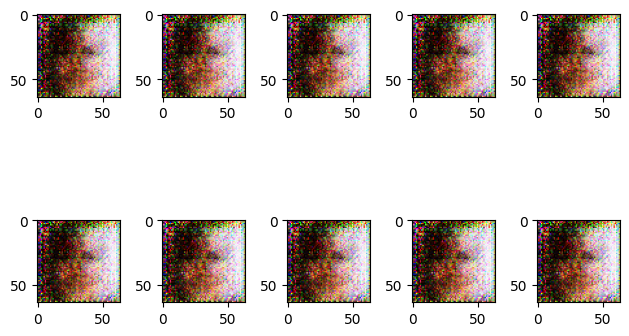

Epoch: 41,  Loss: D_real = 0.5707168579101562, D_fake = 0.5707632899284363,  G = 0.4032331705093384
Epoch:  41
Epoch: 42,  Loss: D_real = 0.574250340461731, D_fake = 0.5742710828781128,  G = 0.4109824001789093
Epoch:  42
Epoch: 43,  Loss: D_real = 0.5776852965354919, D_fake = 0.5777331590652466,  G = 0.41787177324295044
Epoch:  43
Epoch: 44,  Loss: D_real = 0.5814142823219299, D_fake = 0.5814398527145386,  G = 0.42409247159957886
Epoch:  44
Epoch: 45,  Loss: D_real = 0.5845707654953003, D_fake = 0.5845943689346313,  G = 0.4307113289833069
Epoch:  45
Epoch: 46,  Loss: D_real = 0.5876049995422363, D_fake = 0.5876320004463196,  G = 0.436684250831604
Epoch:  46
Epoch: 47,  Loss: D_real = 0.5904844999313354, D_fake = 0.5905086398124695,  G = 0.442330539226532
Epoch:  47
Epoch: 48,  Loss: D_real = 0.5931220054626465, D_fake = 0.5931439995765686,  G = 0.44783756136894226
Epoch:  48
Epoch: 49,  Loss: D_real = 0.5955356359481812, D_fake = 0.5955601334571838,  G = 0.45308807492256165
Epoch:  49


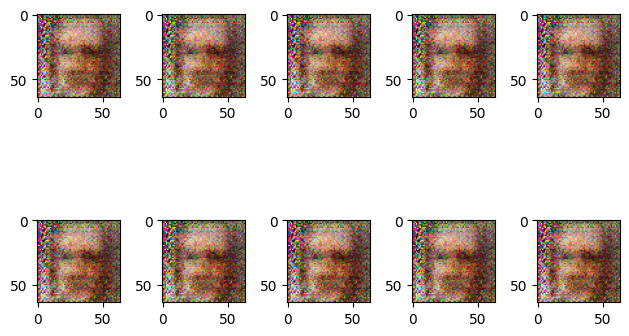

Epoch: 51,  Loss: D_real = 0.6000699400901794, D_fake = 0.600088357925415,  G = 0.46289584040641785
Epoch:  51
Epoch: 52,  Loss: D_real = 0.6020959615707397, D_fake = 0.6021131277084351,  G = 0.46775567531585693
Epoch:  52
Epoch: 53,  Loss: D_real = 0.6040183305740356, D_fake = 0.6040387749671936,  G = 0.4722650349140167
Epoch:  53
Epoch: 54,  Loss: D_real = 0.6062583923339844, D_fake = 0.6062760949134827,  G = 0.4757586121559143
Epoch:  54
Epoch: 55,  Loss: D_real = 0.6080390810966492, D_fake = 0.6080535650253296,  G = 0.48032239079475403
Epoch:  55
Epoch: 56,  Loss: D_real = 0.6097522377967834, D_fake = 0.6097713112831116,  G = 0.48439133167266846
Epoch:  56
Epoch: 57,  Loss: D_real = 0.6117897629737854, D_fake = 0.6118032932281494,  G = 0.4877154231071472
Epoch:  57
Epoch: 58,  Loss: D_real = 0.6134836077690125, D_fake = 0.6134953498840332,  G = 0.49175623059272766
Epoch:  58
Epoch: 59,  Loss: D_real = 0.615106999874115, D_fake = 0.615118682384491,  G = 0.49559304118156433
Epoch:  5

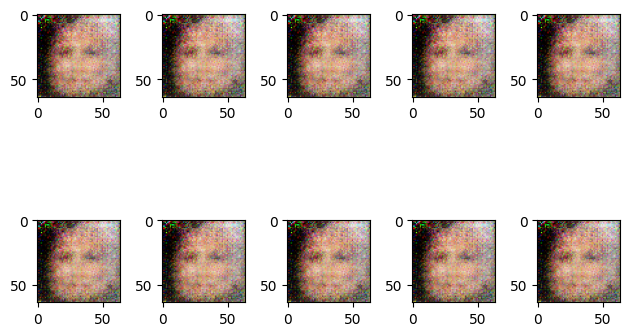

Epoch: 61,  Loss: D_real = 0.6182748079299927, D_fake = 0.6182849407196045,  G = 0.5023915767669678
Epoch:  61
Epoch: 62,  Loss: D_real = 0.6196372509002686, D_fake = 0.619653046131134,  G = 0.5057585835456848
Epoch:  62
Epoch: 63,  Loss: D_real = 0.6211381554603577, D_fake = 0.6211534142494202,  G = 0.5085228085517883
Epoch:  63
Epoch: 64,  Loss: D_real = 0.6225208640098572, D_fake = 0.6225295066833496,  G = 0.5116912722587585
Epoch:  64
Epoch: 65,  Loss: D_real = 0.6237661242485046, D_fake = 0.6237757802009583,  G = 0.5149099826812744
Epoch:  65
Epoch: 66,  Loss: D_real = 0.6250518560409546, D_fake = 0.6250633597373962,  G = 0.5177277326583862
Epoch:  66
Epoch: 67,  Loss: D_real = 0.6262020468711853, D_fake = 0.6262114644050598,  G = 0.5206242799758911
Epoch:  67
Epoch: 68,  Loss: D_real = 0.627299427986145, D_fake = 0.6273131966590881,  G = 0.5233208537101746
Epoch:  68
Epoch: 69,  Loss: D_real = 0.6284468770027161, D_fake = 0.6284538507461548,  G = 0.525899350643158
Epoch:  69
Epoc

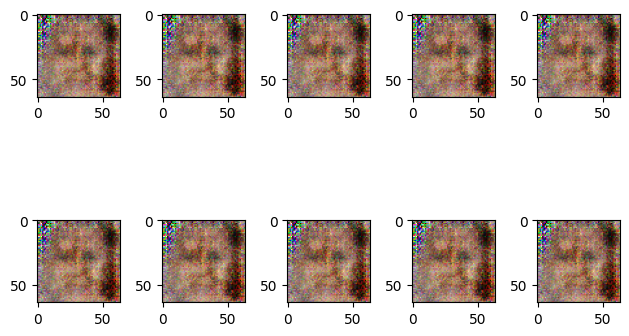

Epoch: 71,  Loss: D_real = 0.6303248405456543, D_fake = 0.6303409337997437,  G = 0.5312060117721558
Epoch:  71
Epoch: 72,  Loss: D_real = 0.6315860748291016, D_fake = 0.6315940022468567,  G = 0.5329824686050415
Epoch:  72
Epoch: 73,  Loss: D_real = 0.6324761509895325, D_fake = 0.6324783563613892,  G = 0.5359266996383667
Epoch:  73
Epoch: 74,  Loss: D_real = 0.6334649920463562, D_fake = 0.6334710717201233,  G = 0.5384464859962463
Epoch:  74
Epoch: 75,  Loss: D_real = 0.6344055533409119, D_fake = 0.6344112753868103,  G = 0.5408385992050171
Epoch:  75
Epoch: 76,  Loss: D_real = 0.6352832913398743, D_fake = 0.6352912783622742,  G = 0.5430984497070312
Epoch:  76
Epoch: 77,  Loss: D_real = 0.6361236572265625, D_fake = 0.6361313462257385,  G = 0.5452479720115662
Epoch:  77
Epoch: 78,  Loss: D_real = 0.6369573473930359, D_fake = 0.6369636654853821,  G = 0.5472955107688904
Epoch:  78
Epoch: 79,  Loss: D_real = 0.637688934803009, D_fake = 0.6376962661743164,  G = 0.5493868589401245
Epoch:  79
Ep

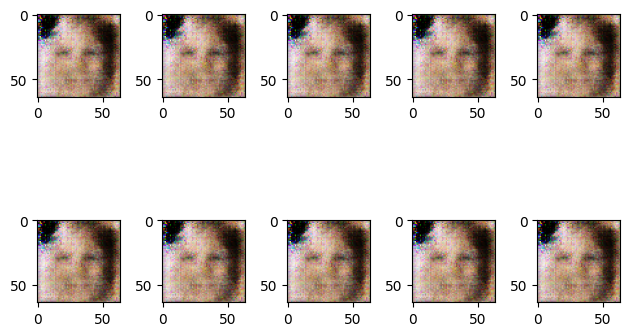

Epoch: 81,  Loss: D_real = 0.639287531375885, D_fake = 0.6392927765846252,  G = 0.553504228591919
Epoch:  81
Epoch: 82,  Loss: D_real = 0.6401129364967346, D_fake = 0.6401175260543823,  G = 0.555437445640564
Epoch:  82
Epoch: 83,  Loss: D_real = 0.640838623046875, D_fake = 0.6408453583717346,  G = 0.5573245882987976
Epoch:  83
Epoch: 84,  Loss: D_real = 0.6415517926216125, D_fake = 0.6415561437606812,  G = 0.5590591430664062
Epoch:  84
Epoch: 85,  Loss: D_real = 0.642177939414978, D_fake = 0.6421838402748108,  G = 0.5609363913536072
Epoch:  85
Epoch: 86,  Loss: D_real = 0.6428549289703369, D_fake = 0.6428588628768921,  G = 0.5626047849655151
Epoch:  86
Epoch: 87,  Loss: D_real = 0.6434339880943298, D_fake = 0.6434386968612671,  G = 0.5643720626831055
Epoch:  87
Epoch: 88,  Loss: D_real = 0.6440520882606506, D_fake = 0.6440667510032654,  G = 0.5658729076385498
Epoch:  88
Epoch: 89,  Loss: D_real = 0.6447318196296692, D_fake = 0.6447344422340393,  G = 0.5675387978553772
Epoch:  89
Epoch:

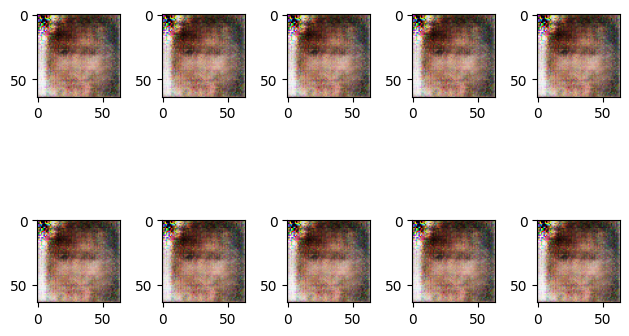

Epoch: 91,  Loss: D_real = 0.6459537148475647, D_fake = 0.6459589600563049,  G = 0.5707703232765198
Epoch:  91
Epoch: 92,  Loss: D_real = 0.646517813205719, D_fake = 0.6465215682983398,  G = 0.5722809433937073
Epoch:  92
Epoch: 93,  Loss: D_real = 0.6470773816108704, D_fake = 0.6470807790756226,  G = 0.5737166404724121
Epoch:  93
Epoch: 94,  Loss: D_real = 0.6475977301597595, D_fake = 0.6476015448570251,  G = 0.5752876996994019
Epoch:  94
Epoch: 95,  Loss: D_real = 0.6481369733810425, D_fake = 0.6481409668922424,  G = 0.5766608715057373
Epoch:  95
Epoch: 96,  Loss: D_real = 0.648626983165741, D_fake = 0.6486323475837708,  G = 0.5781127214431763
Epoch:  96
Epoch: 97,  Loss: D_real = 0.6491539478302002, D_fake = 0.6491547226905823,  G = 0.5796387195587158
Epoch:  97
Epoch: 98,  Loss: D_real = 0.649631917476654, D_fake = 0.6496352553367615,  G = 0.5810825824737549
Epoch:  98
Epoch: 99,  Loss: D_real = 0.6500563025474548, D_fake = 0.6500605940818787,  G = 0.5823556780815125
Epoch:  99
Epoc

In [706]:
for epoch in range(epochs):
    print("Epoch: ",epoch)
    for i in range(batches):

        noise = np.random.uniform(-1,1,size=[batch_size,noise_shape]) #noise of shape 128,100
        gen_img = generator.predict_on_batch(noise)
        # gen_img = generator.predict_on_batch(noise)
        # gen_img += np.random.normal(0, 0.02, size=gen_img.shape)
        # gen_img = np.clip(gen_img, -1.0, 1.0)

        #Train the discriminator

        # real_imgs = X_train[i*batch_size:(i+1)*batch_size]
        # real_imgs += np.random.normal(0, 0.05, size=real_imgs.shape)
        # real_imgs = np.clip(real_imgs, -1.0, 1.0)

        train_dataset = X_train[i * batch_size : (i+1) * batch_size] #Get mini batches
        #Training on real image
        train_label = np.ones(shape = (batch_size,1)) * 0.9 #Real image has output 1
        discriminator.trainable = True #Make it trainable 
        d_loss1 = discriminator.train_on_batch(train_dataset,train_label)
        #Training on the fake image
        train_label = np.zeros(shape = (batch_size,1))
        d_loss2 = discriminator.train_on_batch(gen_img,train_label)

        #Train the generator
        noise = np.random.uniform(-1,1,size=[batch_size,noise_shape])
        train_label = np.ones(shape = (batch_size,1))
        discriminator.trainable = False
        g_loss1  = gan.train_on_batch(noise,train_label)

        d_loss.append(d_loss1 + d_loss2)
        g_loss.append(g_loss1)

    if epoch % 10 == 0:
        fake = generator.predict(np.random.uniform(-1,1,size=[10,noise_shape]))
        for k in range(10):
            plt.subplot(2,5,k+1)
            plt.imshow((fake[k] + 1)/2)
        plt.tight_layout()
        plt.show()
    
    print(f'Epoch: {epoch+1},  Loss: D_real = {d_loss1}, D_fake = {d_loss2},  G = {g_loss1}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


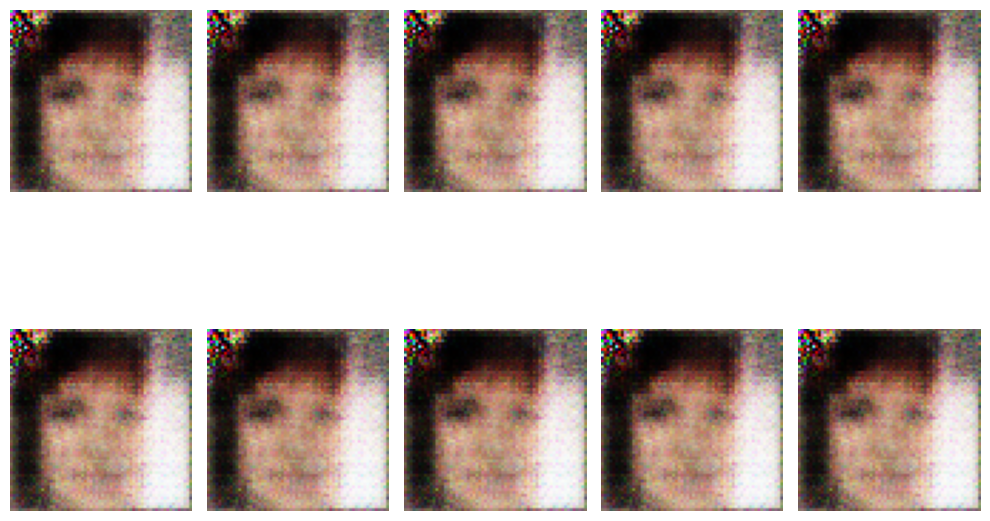

In [707]:
plt.figure(figsize = (10,8))
for i in range(10):
    noise = np.random.uniform(-1,1,size=[10,noise_shape])
    fake = generator.predict(noise)
    plt.subplot(2,5,i+1)
    plt.imshow((fake[i] + 1) / 2)
    plt.axis('off')
plt.tight_layout()
plt.show()

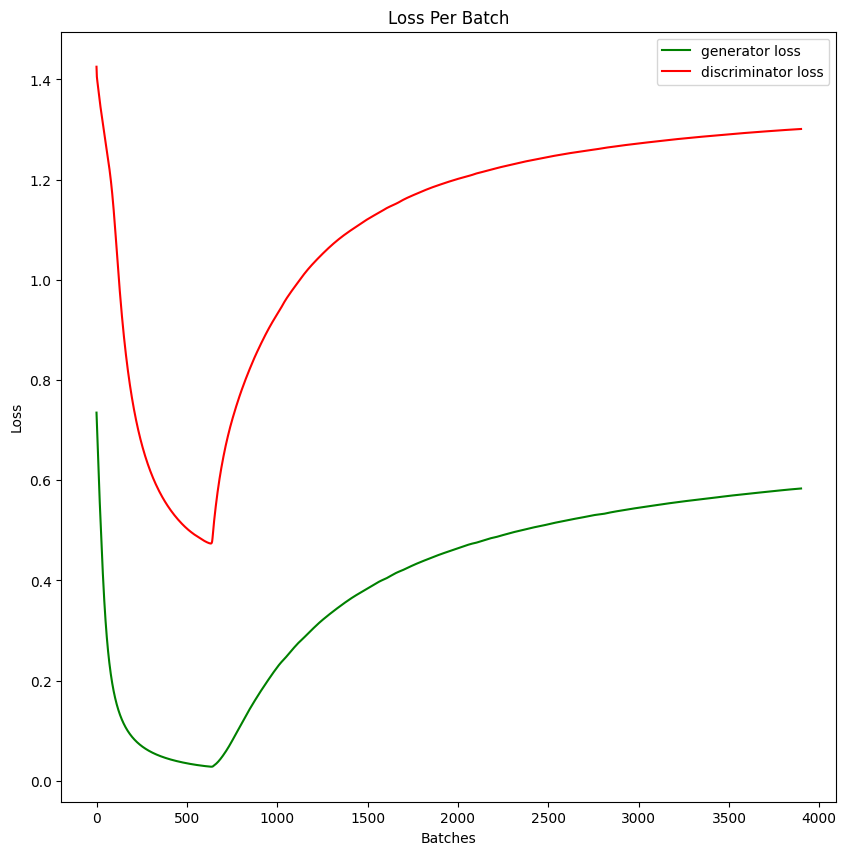

In [708]:
plt.figure(figsize = (10,10))
plt.plot(g_loss,color = 'green',label = 'generator loss')
plt.plot(d_loss,color = 'red', label = 'discriminator loss')
plt.xlabel('Batches')
plt.ylabel('Loss')
plt.title('Loss Per Batch')
plt.legend()
plt.show()

In [709]:
gan.save("faces_dcgan_model.h5")